In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step


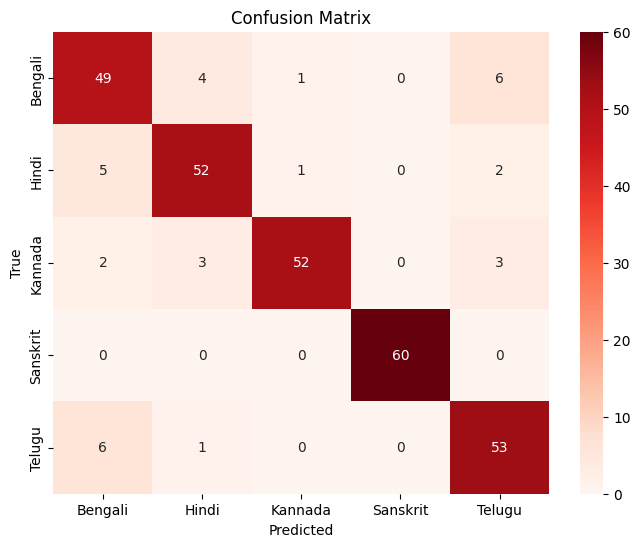

In [ ]:
!pip install seaborn matplotlib


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# To Calculates the accuracy for each language
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
!pip install librosa resampy matplotlib seaborn keras scikit-learn
import os
import librosa
import librosa.display
import resampy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

def extract_mel_spectrogram(audio_path, max_pad_len=174):
    audio, sr = librosa.load(audio_path, res_type='kaiser_fast')
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Resizing the mel spectrogram to a fixed size
    mel_spec_resized = librosa.util.fix_length(mel_spec_db, size=max_pad_len, axis=1)

    return mel_spec_resized

def load_data(input_folder):
    data = []
    labels = []

    class_subdirs = [d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))]

    for i, class_dir in enumerate(class_subdirs):
        class_folder = os.path.join(input_folder, class_dir)
        for file in os.listdir(class_folder):
            if file.endswith('.wav'):
                file_path = os.path.join(class_folder, file)

                try:
                    # Attempt to load the audio file
                    audio, _ = librosa.load(file_path, res_type='kaiser_fast')

                    # Check if the audio file is not empty
                    if len(audio) > 0:
                        mel_spec = extract_mel_spectrogram(file_path)
                        data.append(mel_spec)
                        labels.append(class_dir)
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")

    return np.array(data), np.array(labels)

def load_single_file(file_path):
    mel_spec = extract_mel_spectrogram(file_path)
    return np.expand_dims(mel_spec, axis=0)  # Add batch dimension

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(*input_shape, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add another Conv2D layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Add one more Conv2D layer
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

if __name__ == "__main__":
    # Set the input folders for training and testing
    train_folder = "/content/drive/MyDrive/project3/train"
    test_path = "/content/drive/MyDrive/project3/test"  # This can be a folder or a single file

    # Load training data and labels
    X_train, y_train = load_data(train_folder)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))

    # Reshape input data for CNN
    input_shape = X_train[0].shape  # Shape of the mel spectrogram
    X_train = X_train.reshape(X_train.shape[0], *input_shape, 1)

    # Build and compile the model
    model = build_cnn_model(input_shape)

    # Train the model
    model.fit(X_train, y_train_encoded, epochs=10, batch_size=32)

    # Check if the test path is a file or directory
    if os.path.isfile(test_path):
        # Load and process the single test file
        X_test = load_single_file(test_path)
        X_test = X_test.reshape(X_test.shape[0], *input_shape, 1)

        # Predict the class of the test file
        predictions = model.predict(X_test)
        y_pred = np.argmax(predictions, axis=1)

        # Since we don't have labels for a single file, we'll calculate accuracy for the predicted class only
        class_accuracies = {label: 0 for label in label_encoder.classes_}
        predicted_class = label_encoder.classes_[y_pred[0]]
        class_accuracies[predicted_class] = 100.0

        # Print predicted class and accuracy
        print(f"Predicted class index: {y_pred[0]}")
        print(f"Predicted class label: {predicted_class}")
        print("Class Accuracies:")
        for language, accuracy in class_accuracies.items():
            print(f"{language}: {accuracy}%")

    else:
        # Load test data and labels
        X_test, y_test = load_data(test_path)

        # Encode test labels
        y_test_encoded = to_categorical(label_encoder.transform(y_test))

        # Reshape input data for CNN
        X_test = X_test.reshape(X_test.shape[0], *input_shape, 1)

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
        print(f"Test Accuracy: {test_acc * 100:.2f}%")  # accuracy in percentage

        # Calculate accuracy for each language
        predictions = model.predict(X_test)
        y_pred = np.argmax(predictions, axis=1)
        y_true = np.argmax(y_test_encoded, axis=1)

        class_accuracies = {}
        for class_label in range(len(label_encoder.classes_)):
            class_indices = np.where(y_true == class_label)
            class_accuracy = np.sum(y_pred[class_indices] == y_true[class_indices]) / len(class_indices[0])
            class_accuracies[label_encoder.classes_[class_label]] = class_accuracy * 100  # Converting to percentage

        print("Class Accuracies:")
        for language, accuracy in class_accuracies.items():
            print(f"{language}: {accuracy:.2f}%")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.2879 - loss: 30.1842
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6654 - loss: 0.7422
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8061 - loss: 0.5088
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8939 - loss: 0.3518
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8860 - loss: 0.2940
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9354 - loss: 0.1772
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9826 - loss: 0.0717
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9762 - loss: 0.0676
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9841 - loss: 0.0459
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9869 - loss: 0.0452
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.8814 - loss: 0.4322
Test Accuracy: 88.67%
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 582ms/step
Class Accuracies:
Be